INFO: Rozpoczynam proces trenowania modelu ElasticNetCV.
INFO: Dane i metadane wczytane pomyślnie.
INFO: Rozpoczynam trenowanie modelu ElasticNetCV z walidacją krzyżową...
INFO: Stosowanie stałej korekty celu (y) dla ElasticNet...
INFO: Obniżono cel dla 61 próbek o 0.75.
INFO: Obniżono cel dla 25 próbek o 0.85.
INFO: Trening zakończony.
INFO: Najlepsza wartość alpha: 0.06551
INFO: Najlepsza wartość l1_ratio: 0.99
INFO: 
Rozpoczynam ewaluację modelu na zbiorze testowym...

WYNIKI EWALUACJI - ELASTICNET CV
Błąd średniokwadratowy (MSE): 0.0567
Pierwiastek błędu średniokwadratowego (RMSE): 0.2381
Błąd średni bezwzględny (MAE): 0.1702
Współczynnik determinacji (R^2): 0.7232
INFO: 
INFO: WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)
INFO: ============================================================
INFO: Średni kurs rzeczywisty: 1.5789
INFO: Średni kurs modelu (przed kalibracją): 1.5549
INFO: 1. KALIBRACJA PROPORCJONALNA (Warunek Sprawiedliwości)
INFO:    - Średni kurs rzeczywisty:      

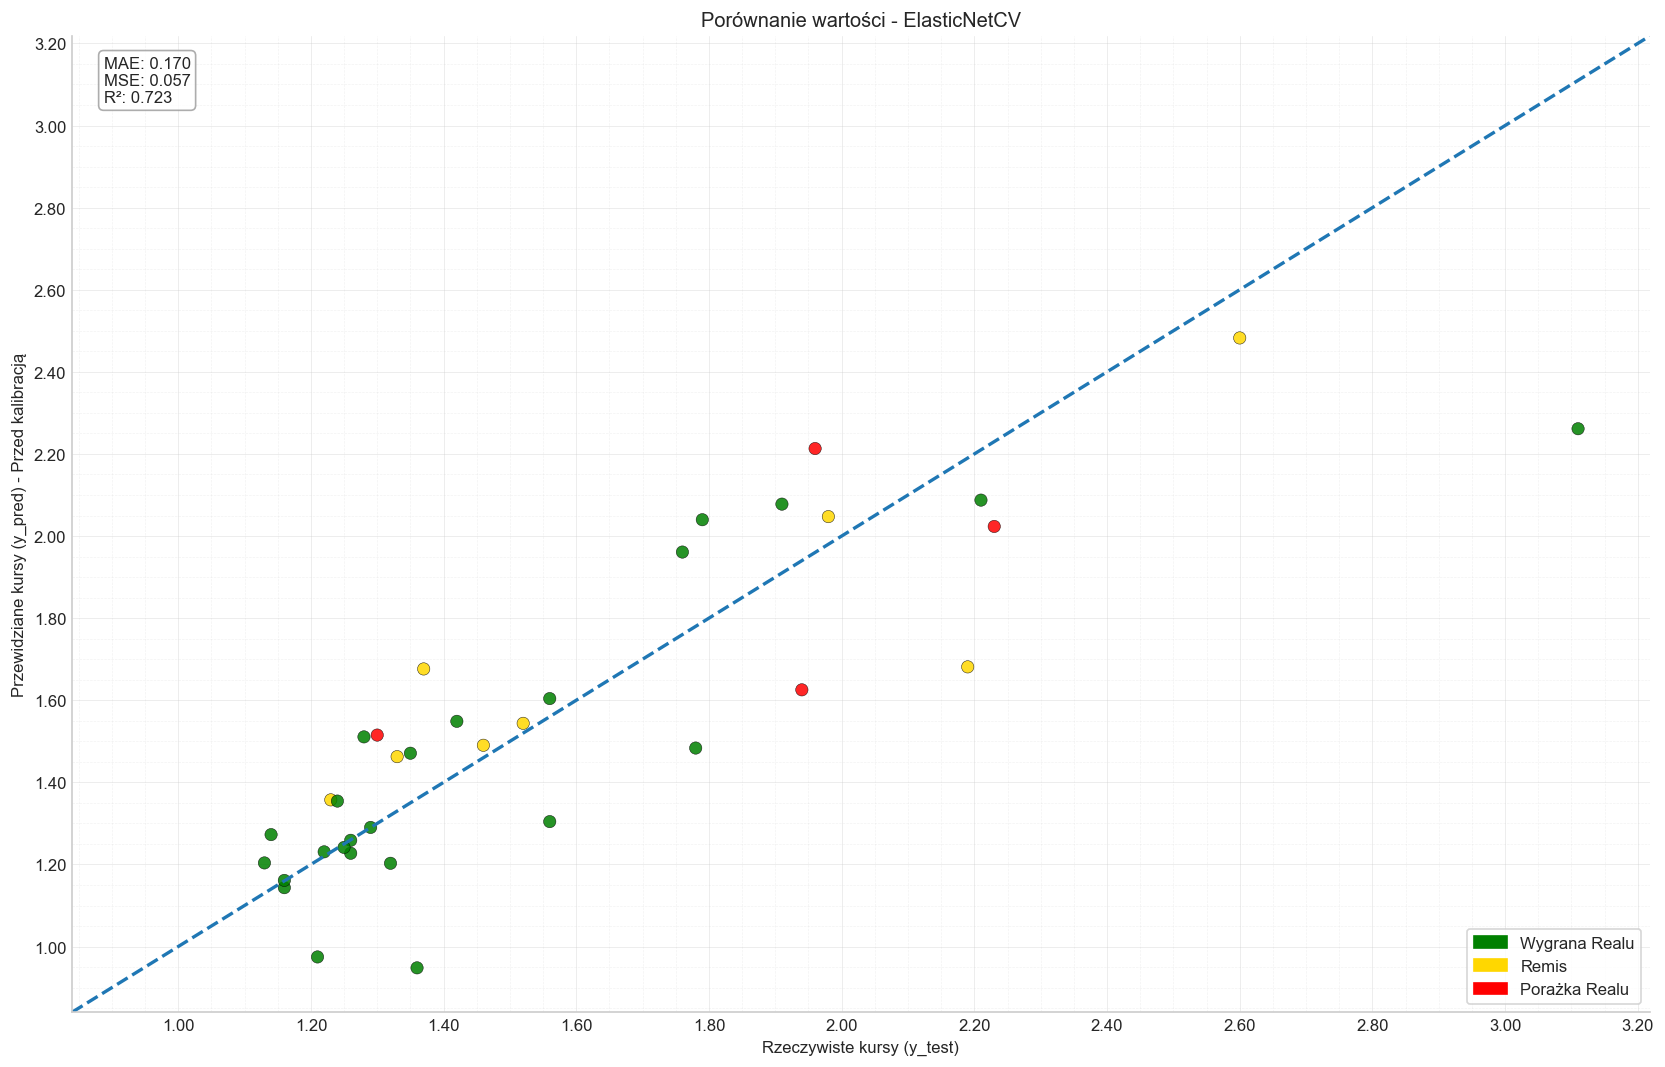

INFO: Skrypt zakończył działanie.


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- KROK 1: Konfiguracja Ścieżek i Import Danych ---

current_dir = os.getcwd()
src_dir = os.path.dirname(os.path.dirname(current_dir))
project_root = os.path.dirname(src_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from src.helpers.file_utils import FileUtils
from src.helpers.logger import info, error

info("Rozpoczynam proces trenowania modelu ElasticNetCV.")

PROCESSED_DATA_DIR = os.path.join(FileUtils.get_project_root(), 'ProcessedForModeling')
RAW_DATA_PATH = os.path.join(FileUtils.get_project_root(), 'Data', 'DataSet', 'real_madrid_master_dataset_win.csv')
DATA_DIR = os.path.join(FileUtils.get_project_root(), 'Data')

try:
    X_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'))
    y_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_train.csv')).values.ravel()
    X_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'))
    y_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test.csv')).values.ravel()

    # Metadane do wizualizacji (zsynchronizowane chronologicznie)
    master_df = FileUtils.load_csv_safe(RAW_DATA_PATH)
    master_df['M_DATE'] = pd.to_datetime(master_df['M_DATE'], errors='coerce')
    master_df = master_df.sort_values('M_DATE').reset_index(drop=True)

    num_test_samples = len(X_test)
    test_metadata = master_df[['MATCH_ID', 'M_DATE', 'SEASON', 'OPP_ID', 'is_real_madrid_win']].tail(num_test_samples).reset_index(drop=True)

    info("Dane i metadane wczytane pomyślnie.")
except FileNotFoundError as e:
    error(f"Nie znaleziono pliku: {e.filename}.")
    sys.exit(1)

# --- KROK 2: Trenowanie Modelu ElasticNetCV ---

info("Rozpoczynam trenowanie modelu ElasticNetCV z walidacją krzyżową...")

# ElasticNetCV testuje kombinacje alpha i l1_ratio
elasticnet_cv_model = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=np.logspace(-4, -1, 50),
    cv=TimeSeriesSplit(n_splits=5),  # walidacja czasowa
    max_iter=10000,
    n_jobs=-1
)

# Stała korekta celu (y) spójna z innymi algorytmami
info("Stosowanie stałej korekty celu (y) dla ElasticNet...")
y_train_adjusted = y_train.copy()
correction_value_for_bigger_courses = 0.75
correction_value_for_lower_courses = 0.85

bigger_odds_indices = (y_train >= 1.30) & (y_train <= 1.60)
lower_odds_indices = (y_train < 1.30)

y_train_adjusted[bigger_odds_indices] *= correction_value_for_bigger_courses
y_train_adjusted[lower_odds_indices] *= correction_value_for_lower_courses

info(f"Obniżono cel dla {np.sum(bigger_odds_indices)} próbek o {correction_value_for_bigger_courses}.")
info(f"Obniżono cel dla {np.sum(lower_odds_indices)} próbek o {correction_value_for_lower_courses}.")

elasticnet_cv_model.fit(X_train, y_train_adjusted)
info("Trening zakończony.")
info(f"Najlepsza wartość alpha: {elasticnet_cv_model.alpha_:.5f}")
info(f"Najlepsza wartość l1_ratio: {elasticnet_cv_model.l1_ratio_:.2f}")

# --- KROK 3: Ewaluacja Statystyczna ---

info("\nRozpoczynam ewaluację modelu na zbiorze testowym...")
y_pred_elastic = elasticnet_cv_model.predict(X_test)

mse_elastic = mean_squared_error(y_test, y_pred_elastic)
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

print("\n" + "="*60)
print("WYNIKI EWALUACJI - ELASTICNET CV")
print("="*60)
print(f"Błąd średniokwadratowy (MSE): {mse_elastic:.4f}")
print(f"Pierwiastek błędu średniokwadratowego (RMSE): {np.sqrt(mse_elastic):.4f}")
print(f"Błąd średni bezwzględny (MAE): {mae_elastic:.4f}")
print(f"Współczynnik determinacji (R^2): {r2_elastic:.4f}")
print("="*60)

# --- KROK 3.5: Ewaluacja Biznesowa z Kalibracją Kursów ---

info("\n" + "="*60)
info("WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)")
info("="*60)

# 1) Kalibracja proporcjonalna
mean_real_odds = float(np.mean(y_test))
mean_pred_odds_raw = float(np.mean(y_pred_elastic))
info(f"Średni kurs rzeczywisty: {mean_real_odds:.4f}")
info(f"Średni kurs modelu (przed kalibracją): {mean_pred_odds_raw:.4f}")

proportional_calibration_factor = mean_real_odds / mean_pred_odds_raw if mean_pred_odds_raw != 0 else 1.0
y_pred_calibrated = y_pred_elastic * proportional_calibration_factor
mean_pred_odds_calibrated = float(np.mean(y_pred_calibrated))

# Zapis porównania do CSV
df = pd.DataFrame()
df['MATCH_ID'] = test_metadata['MATCH_ID'].values
df['M_DATE'] = test_metadata['M_DATE'].values
df['SEASON'] = test_metadata['SEASON'].values
df['OPP_ID'] = test_metadata['OPP_ID'].values
df[' (W=1, R=0.5, P=0)'] = test_metadata['is_real_madrid_win'].values
df['Real Course'] = y_test
df['Pred Cource before calibration'] = np.round(y_pred_elastic, 3)
df['Pred Cource after calibration'] = np.round(y_pred_calibrated, 3)

FileUtils.save_csv_safe(df, os.path.join(DATA_DIR, 'Model_result', 'PRED_odds_comparison_ELASTICNET.csv'))

info("1. KALIBRACJA PROPORCJONALNA (Warunek Sprawiedliwości)")
info(f"   - Średni kurs rzeczywisty:          {mean_real_odds:.4f}")
info(f"   - Średni kurs modelu (przed kal.):   {mean_pred_odds_raw:.4f}")
info(f"   - Zastosowany współczynnik kalibracji (mnożnik): {proportional_calibration_factor:.4f}")
info(f"   - Średni kurs modelu (po kal.):      {mean_pred_odds_calibrated:.4f}")
info("   - WNIOSEK: Kursy skalibrowane. Można przeprowadzić analizę finansową.")
info("-"*60)

# 2) Analiza wypłat: suma i iloczyn
win_mask = (test_metadata['is_real_madrid_win'] == 1)
draw_or_loss_mask = (test_metadata['is_real_madrid_win'] != 1)

payout_real_wins = float(np.sum(y_test[win_mask]))
payout_pred_wins = float(np.sum(y_pred_calibrated[win_mask]))
payout_real_non_wins = float(np.sum(y_test[draw_or_loss_mask]))
payout_pred_non_wins = float(np.sum(y_pred_calibrated[draw_or_loss_mask]))

payout_difference_win = payout_real_wins - payout_pred_wins
payout_difference_non_win = payout_real_non_wins - payout_pred_non_wins

# Iloczyny
combined_real_wins = float(np.prod(y_test[win_mask])) if np.any(win_mask) else np.nan
combined_pred_wins = float(np.prod(y_pred_calibrated[win_mask])) if np.any(win_mask) else np.nan
combined_real_non_wins = float(np.prod(y_test[draw_or_loss_mask])) if np.any(draw_or_loss_mask) else np.nan
combined_pred_non_wins = float(np.prod(y_pred_calibrated[draw_or_loss_mask])) if np.any(draw_or_loss_mask) else np.nan

wins_ratio = (combined_real_wins / combined_pred_wins) if (combined_pred_wins and combined_pred_wins != 0) else np.nan
non_wins_ratio = (combined_real_non_wins / combined_pred_non_wins) if (combined_pred_non_wins and combined_pred_non_wins != 0) else np.nan

info(f"2.1 ANALIZA WYPŁAT SUMY (dla {np.sum(win_mask)} wygranych meczy)")
info(f"   - Suma wypłat wg. kursów rzeczywistych: {payout_real_wins:.2f}")
info(f"   - Suma wypłat wg. kursów modelu:        {payout_pred_wins:.2f}")
info(f"   - Różnica (real - model): {payout_difference_win:.2f}")
if payout_real_wins > payout_pred_wins:
    info("   - WNIOSEK: Model jest LEPSZY (mniejsze wypłaty).")
else:
    info("   - WNIOSEK: Model jest GORSZY (większe wypłaty).")
info("-"*60)

info(f"2.2 ANALIZA WYPŁAT ILOCZYNU (dla {np.sum(win_mask)} wygranych meczy)")
info(f"   - Skumulowany kurs (real):  {combined_real_wins:.6g}")
info(f"   - Skumulowany kurs (model): {combined_pred_wins:.6g}")
info(f"   - Iloraz (real/model): {wins_ratio:.6g}")
if combined_real_wins > combined_pred_wins:
    info("   - WNIOSEK: Model jest LEPSZY (mniejsze skumulowane wypłaty).")
else:
    info("   - WNIOSEK: Model jest GORSZY (większe skumulowane wypłaty).")
info("-"*60)

info("3.1 Mecze bez wygranej Realu (SUMA)")
info(f"   - Suma kursów rzeczywistych: {payout_real_non_wins:.2f}")
info(f"   - Suma kursów modelu:        {payout_pred_non_wins:.2f}")
if payout_real_non_wins > payout_pred_non_wins:
    info("   - WNIOSEK: Model jest GORSZY (mniejsze straty).")
else:
    info("   - WNIOSEK: Model jest LEPSZY (większe straty).")
info("-"*60)

info("3.2 Mecze bez wygranej Realu (ILOCZYN)")
info(f"   - Skumulowany kurs (real):  {combined_real_non_wins:.6g}")
info(f"   - Skumulowany kurs (model): {combined_pred_non_wins:.6g}")
if combined_real_non_wins > combined_pred_non_wins:
    info("   - WNIOSEK: Model jest GORSZY (mniejsze skumulowane straty).")
else:
    info("   - WNIOSEK: Model jest LEPSZY (większe skumulowane straty).")
info("-"*60)

info("\nGenerowanie wizualizacji wyników z kolorowaniem...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
plt.style.use('seaborn-v0_8-whitegrid')

# Kolory punktów wg wyniku meczu
color_map = {1: 'green', 0.5: 'gold', 0: 'red'}
point_colors = test_metadata['is_real_madrid_win'].map(color_map)

# Zakresy osi z lekkim marginesem i symetrią względem y=x
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min, y_max = float(np.min(y_pred_elastic)), float(np.max(y_pred_elastic))
lo = min(x_min, y_min)
hi = max(x_max, y_max)
pad = 0.05 * (hi - lo) if hi > lo else 0.1
xmin, xmax = lo - pad, hi + pad
ymin, ymax = xmin, xmax  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng = xmax - xmin
if rng <= 1.0:
    major, minor = 0.05, 0.01
elif rng <= 2.0:
    major, minor = 0.10, 0.02
else:
    major, minor = 0.20, 0.05

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)

# Punkty
ax.scatter(y_test, y_pred_elastic, c=point_colors, alpha=0.85, s=55, edgecolors='k', linewidths=0.3)

# Linia referencyjna y=x
ax.plot([xmin, xmax], [xmin, xmax], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Rzeczywiste kursy (y_test)")
ax.set_ylabel("Przewidziane kursy (y_pred) - Przed kalibracją")
ax.set_title("Porównanie wartości - ElasticNetCV")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major))
ax.yaxis.set_major_locator(MultipleLocator(major))
subdiv = max(1, int(round(major/minor))) if minor > 0 else 1
ax.xaxis.set_minor_locator(AutoMinorLocator(subdiv))
ax.yaxis.set_minor_locator(AutoMinorLocator(subdiv))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25)

# Legenda
win_patch = mpatches.Patch(color='green', label='Wygrana Realu')
draw_patch = mpatches.Patch(color='gold', label='Remis')
loss_patch = mpatches.Patch(color='red', label='Porażka Realu')
ax.legend(handles=[win_patch, draw_patch, loss_patch], frameon=True)

# Metryki na wykresie
try:
    ax.text(0.02, 0.98, f"MAE: {mae_elastic:.3f}\nMSE: {mse_elastic:.3f}\nR²: {r2_elastic:.3f}",
            transform=ax.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#999'))
except NameError:
    pass

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

info("Skrypt zakończył działanie.")
# ...existing

INFO: 
Generowanie wizualizacji wyników z kolorowaniem...


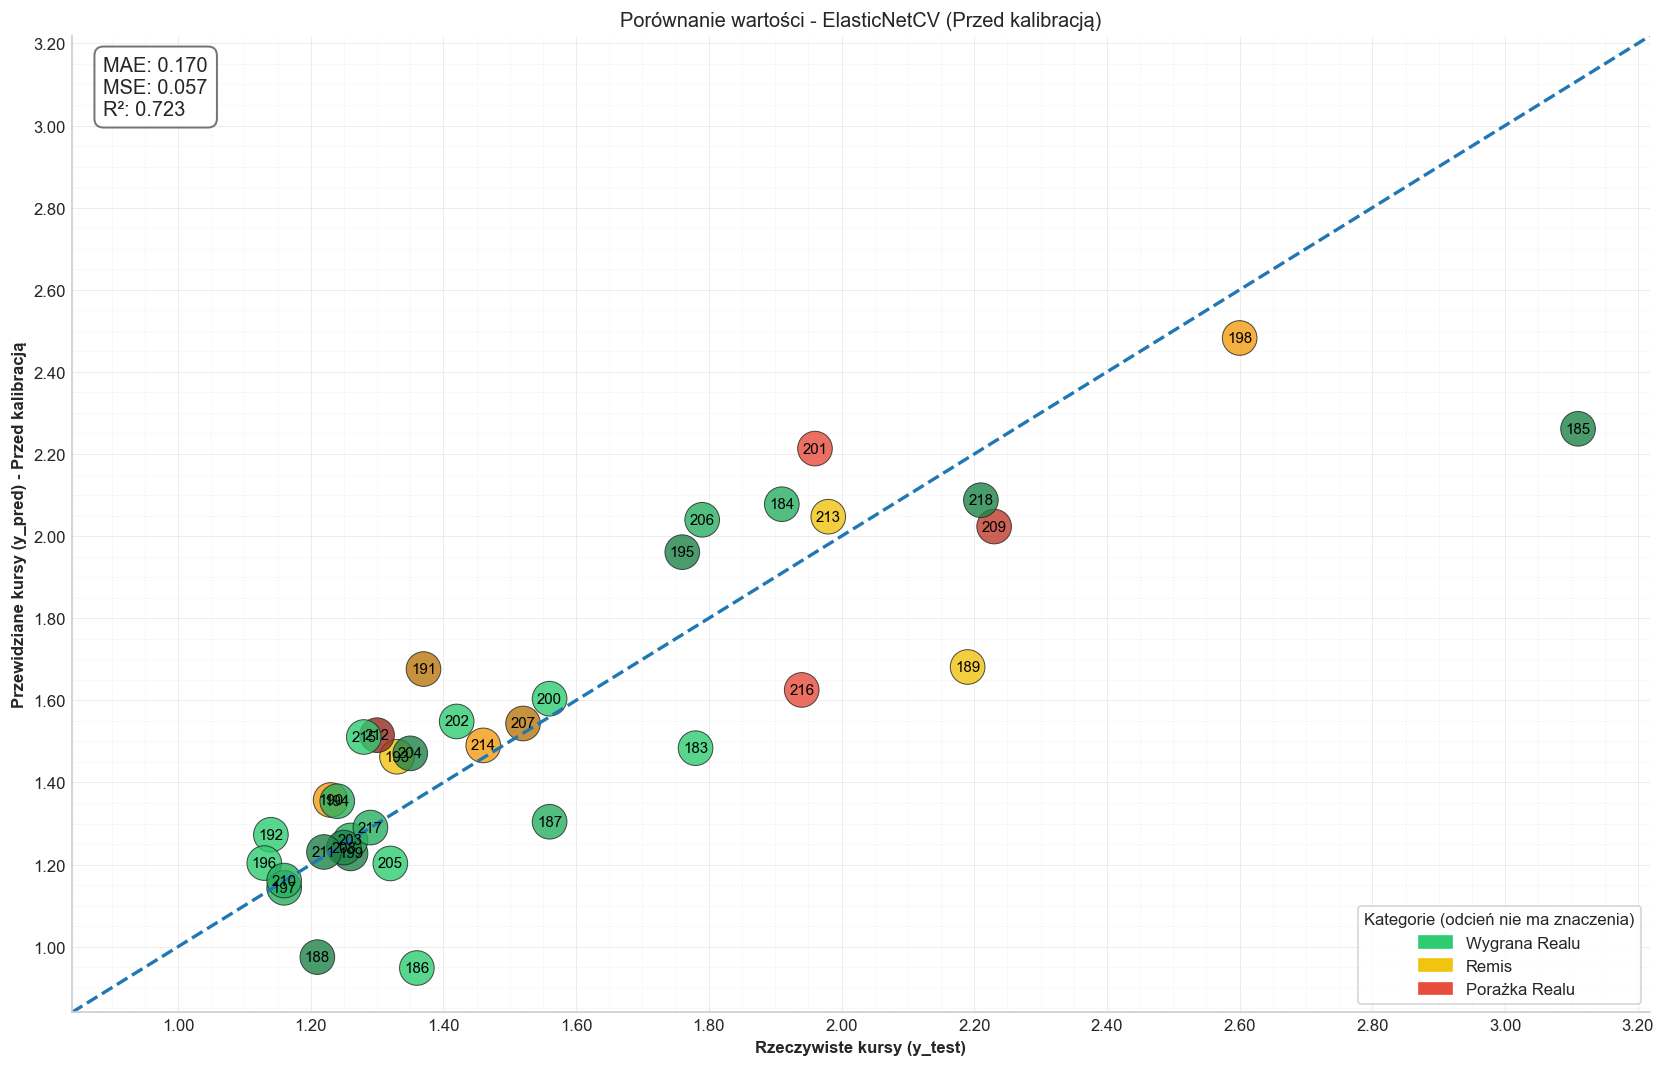

In [2]:
# ...existing code...
# --- KROK 5A: Wizualizacja wyników PRZED kalibracją ---

info("\nGenerowanie wizualizacji wyników z kolorowaniem...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe  # można usunąć, jeśli nie używasz path_effects

# Kolory punktów wg wyniku meczu (różne odcienie w obrębie klas)
outcomes = test_metadata['is_real_madrid_win'].values
match_ids = test_metadata['MATCH_ID'].astype(str).values

def shaded_color_series(labels):
    palettes = {
        1: ['#2ecc71', '#27ae60', '#1e8449'],      # odcienie zieleni
        0.5: ['#f1c40f', '#f39c12', '#b9770e'],    # odcienie złota
        0: ['#e74c3c', '#c0392b', '#922b21'],      # odcienie czerwieni
    }
    counters = {1: 0, 0.5: 0, 0: 0}
    colors = []
    for lab in labels:
        pal = palettes.get(lab, ['#95a5a6'])
        idx = counters.get(lab, 0) % len(pal)
        colors.append(pal[idx])
        counters[lab] = counters.get(lab, 0) + 1
    return colors

point_colors = shaded_color_series(outcomes)
text_color_by_label = {1: 'black', 0.5: 'black', 0: 'black'}

# Zakresy osi (dla prognoz przed kalibracją)
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_pc, y_max_pc = float(np.min(y_pred_elastic)), float(np.max(y_pred_elastic))
lo_pc = min(x_min, y_min_pc)
hi_pc = max(x_max, y_max_pc)
pad_pc = 0.05 * (hi_pc - lo_pc) if hi_pc > lo_pc else 0.1
xmin_pc, xmax_pc = lo_pc - pad_pc, hi_pc + pad_pc
ymin_pc, ymax_pc = xmin_pc, xmax_pc  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng_pc = xmax_pc - xmin_pc
if rng_pc <= 1.0:
    major_pc, minor_pc = 0.05, 0.01
elif rng_pc <= 2.0:
    major_pc, minor_pc = 0.10, 0.02
else:
    major_pc, minor_pc = 0.20, 0.05

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)
ax.set_axisbelow(True)  # siatka pod danymi

# Parametry czytelności (duże markery)
marker_size = int(360 * 1.2)  # 432
marker_alpha = 0.8
font_size = 9

# Punkty przed kalibracją
ax.scatter(
    y_test, y_pred_elastic,
    c=point_colors,
    alpha=marker_alpha,
    s=marker_size,
    edgecolors='#222',
    linewidths=0.6,
    zorder=2
)

# Etykiety MATCH_ID w środku punktów
for x, y, mid, lab in zip(y_test, y_pred_elastic, match_ids, outcomes):
    ax.text(
        x, y, mid,
        ha='center', va='center',
        fontsize=font_size,
        color=text_color_by_label.get(lab, 'black'),
        zorder=6,
        clip_on=False
    )

# Linia referencyjna y=x
ax.plot([xmin_pc, xmax_pc], [xmin_pc, xmax_pc], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_pc, xmax_pc)
ax.set_ylim(ymin_pc, ymax_pc)
ax.set_xlabel("Rzeczywiste kursy (y_test)", fontweight='bold')
ax.set_ylabel("Przewidziane kursy (y_pred) - Przed kalibracją", fontweight='bold')
ax.set_title("Porównanie wartości - ElasticNetCV (Przed kalibracją)")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_pc))
ax.yaxis.set_major_locator(MultipleLocator(major_pc))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major_pc/minor_pc)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major_pc/minor_pc)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35, zorder=1)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25, zorder=1)

# Legenda (bazowe barwy kategorii; odcień punktów nie ma znaczenia)
base_colors = {1: '#2ecc71', 0.5: '#f1c40f', 0: '#e74c3c'}
win_patch = mpatches.Patch(color=base_colors[1], label='Wygrana Realu')
draw_patch = mpatches.Patch(color=base_colors[0.5], label='Remis')
loss_patch = mpatches.Patch(color=base_colors[0], label='Porażka Realu')
ax.legend(
    handles=[win_patch, draw_patch, loss_patch],
    frameon=True,
    title='Kategorie (odcień nie ma znaczenia)'
)

# Metryki na wykresie (większe okno i czcionka)
try:
    ax.text(
        0.02, 0.98,
        f"MAE: {mae_elastic:.3f}\nMSE: {mse_elastic:.3f}\nR²: {r2_elastic:.3f}",
        transform=ax.transAxes, va='top', ha='left',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.45', facecolor='white', alpha=0.9, edgecolor='#666', linewidth=1.2),
        zorder=7
    )
except NameError:
    pass

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
# ...existing code...

INFO: 
Generowanie wizualizacji wyników po kalibracji kursów...


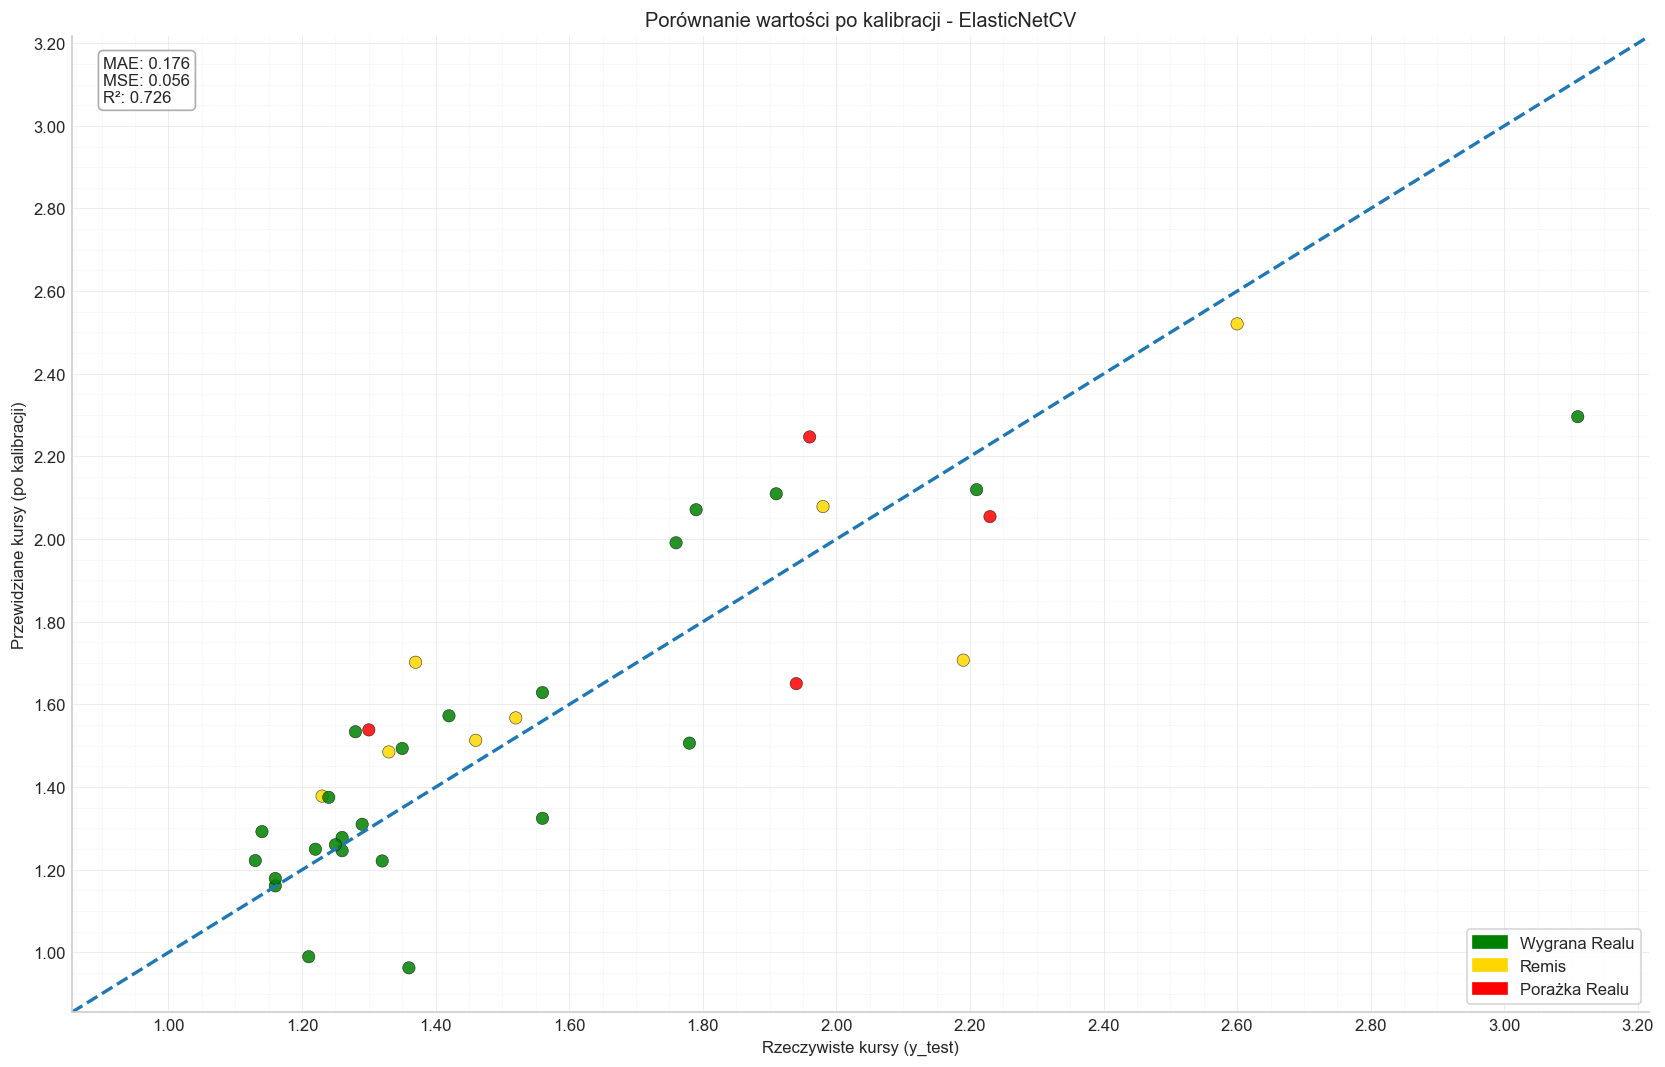

In [3]:

# --- KROK 5B: Wizualizacja wyników PO kalibracji kursów ---

info("\nGenerowanie wizualizacji wyników po kalibracji kursów...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
plt.style.use('seaborn-v0_8-whitegrid')

# Kolory punktów wg wyniku meczu
color_map = {1: 'green', 0.5: 'gold', 0: 'red'}
point_colors = test_metadata['is_real_madrid_win'].map(color_map)

# Zakresy osi (dla prognoz po kalibracji) – symetryczne względem y=x
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_c, y_max_c = float(np.min(y_pred_calibrated)), float(np.max(y_pred_calibrated))
lo_c = min(x_min, y_min_c)
hi_c = max(x_max, y_max_c)
pad_c = 0.05 * (hi_c - lo_c) if hi_c > lo_c else 0.1
xmin_c, xmax_c = lo_c - pad_c, hi_c + pad_c
ymin_c, ymax_c = xmin_c, xmax_c

# Dynamiczna gęstość podziałki
rng_c = xmax_c - xmin_c
if rng_c <= 1.0:
    major_c, minor_c = 0.05, 0.01
elif rng_c <= 2.0:
    major_c, minor_c = 0.10, 0.02
else:
    major_c, minor_c = 0.20, 0.05

# Metryki po kalibracji
mse_elastic_cal = mean_squared_error(y_test, y_pred_calibrated)
mae_elastic_cal = mean_absolute_error(y_test, y_pred_calibrated)
r2_elastic_cal = r2_score(y_test, y_pred_calibrated)

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)

# Punkty po kalibracji
ax.scatter(y_test, y_pred_calibrated, c=point_colors, alpha=0.85, s=55, edgecolors='k', linewidths=0.3)

# Linia referencyjna y=x
ax.plot([xmin_c, xmax_c], [xmin_c, xmax_c], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_c, xmax_c)
ax.set_ylim(ymin_c, ymax_c)
ax.set_xlabel("Rzeczywiste kursy (y_test)")
ax.set_ylabel("Przewidziane kursy (po kalibracji)")
ax.set_title("Porównanie wartości po kalibracji - ElasticNetCV")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_c))
ax.yaxis.set_major_locator(MultipleLocator(major_c))
subdiv_c = max(1, int(round(major_c/minor_c))) if minor_c > 0 else 1
ax.xaxis.set_minor_locator(AutoMinorLocator(subdiv_c))
ax.yaxis.set_minor_locator(AutoMinorLocator(subdiv_c))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25)

# Legenda
win_patch = mpatches.Patch(color='green', label='Wygrana Realu')
draw_patch = mpatches.Patch(color='gold', label='Remis')
loss_patch = mpatches.Patch(color='red', label='Porażka Realu')
ax.legend(handles=[win_patch, draw_patch, loss_patch], frameon=True)

# Metryki na wykresie (po kalibracji)
ax.text(0.02, 0.98, f"MAE: {mae_elastic_cal:.3f}\nMSE: {mse_elastic_cal:.3f}\nR²: {r2_elastic_cal:.3f}",
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#999'))

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# plt.savefig(os.path.join(FileUtils.get_project_root(), 'img', 'ELASTICNET_calibrated.png'), dpi=140)
plt.show()


INFO: 
Generowanie wizualizacji wyników po kalibracji kursów...


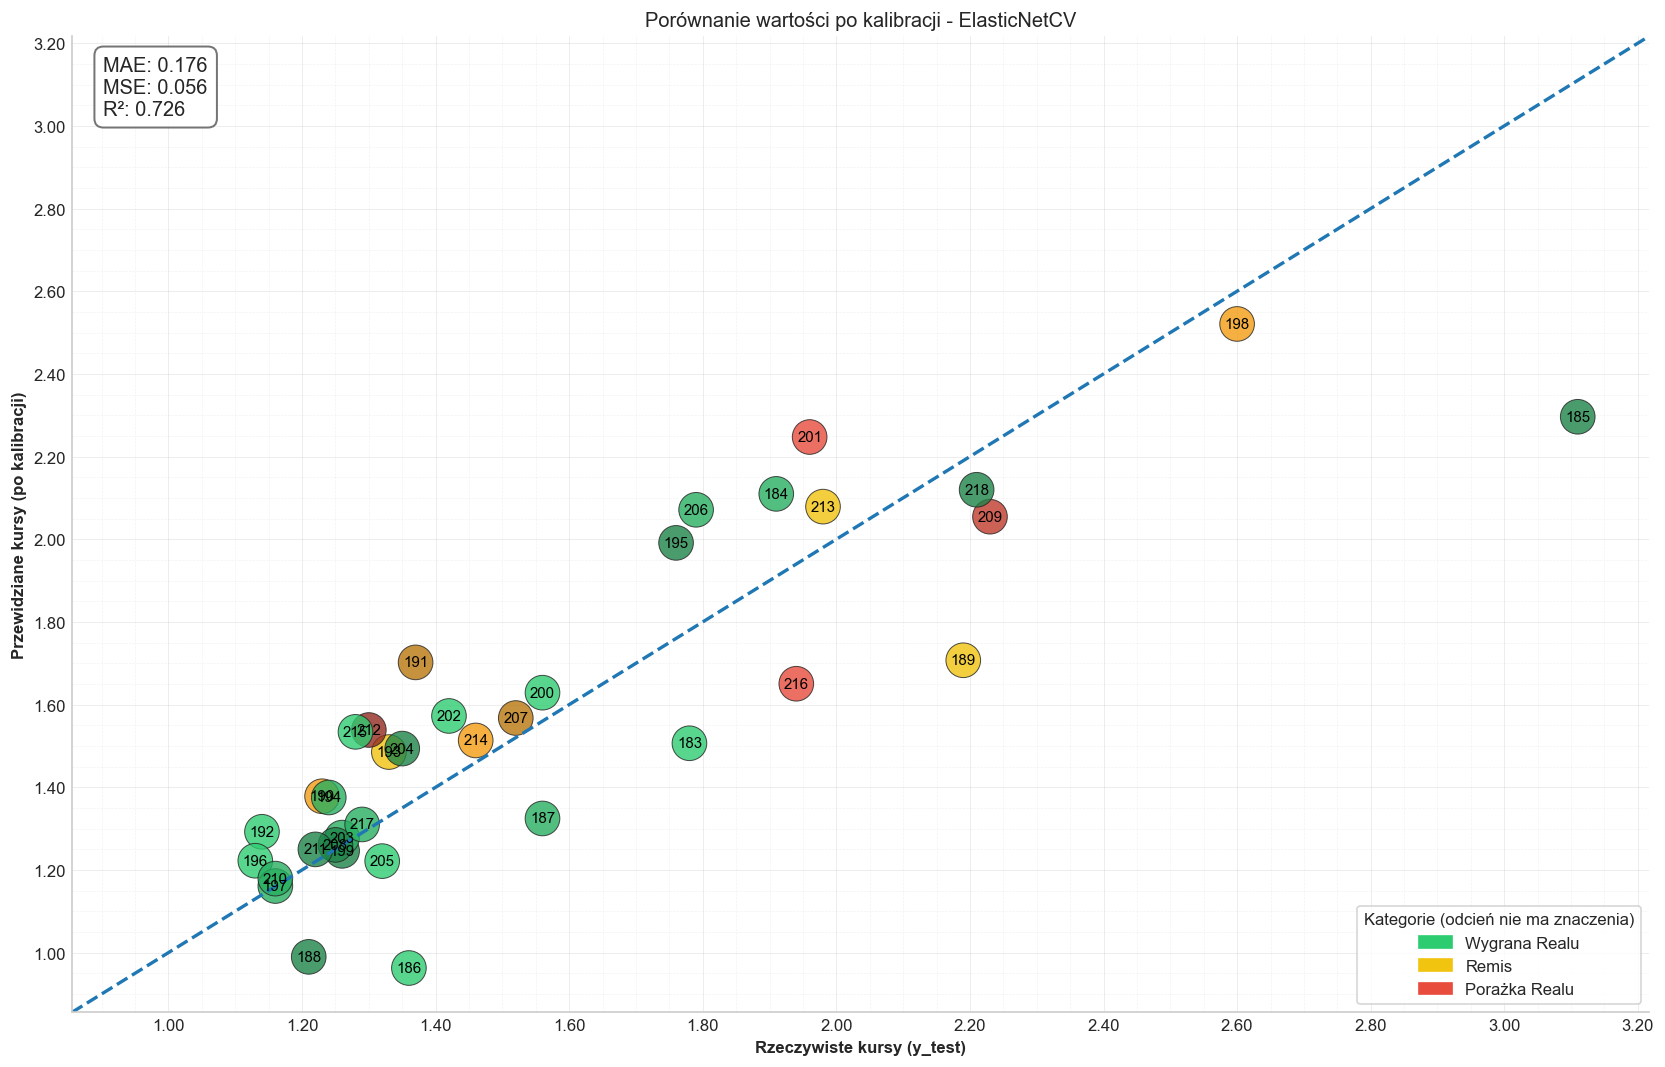

In [4]:
# ...existing code...
# --- KROK 5B: Wizualizacja wyników PO kalibracji kursów ---

info("\nGenerowanie wizualizacji wyników po kalibracji kursów...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe  # można usunąć, jeśli nie używasz path_effects

# Kolory punktów wg wyniku meczu (różne odcienie w obrębie klas)
outcomes = test_metadata['is_real_madrid_win'].values
match_ids = test_metadata['MATCH_ID'].astype(str).values

def shaded_color_series(labels):
    palettes = {
        1: ['#2ecc71', '#27ae60', '#1e8449'],      # odcienie zieleni
        0.5: ['#f1c40f', '#f39c12', '#b9770e'],    # odcienie złota
        0: ['#e74c3c', '#c0392b', '#922b21'],      # odcienie czerwieni
    }
    counters = {1: 0, 0.5: 0, 0: 0}
    colors = []
    for lab in labels:
        pal = palettes.get(lab, ['#95a5a6'])
        idx = counters.get(lab, 0) % len(pal)
        colors.append(pal[idx])
        counters[lab] = counters.get(lab, 0) + 1
    return colors

point_colors = shaded_color_series(outcomes)
text_color_by_label = {1: 'black', 0.5: 'black', 0: 'black'}

# Zakresy osi (dla prognoz po kalibracji)
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_c, y_max_c = float(np.min(y_pred_calibrated)), float(np.max(y_pred_calibrated))
lo_c = min(x_min, y_min_c)
hi_c = max(x_max, y_max_c)
pad_c = 0.05 * (hi_c - lo_c) if hi_c > lo_c else 0.1
xmin_c, xmax_c = lo_c - pad_c, hi_c + pad_c
ymin_c, ymax_c = xmin_c, xmax_c  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng_c = xmax_c - xmin_c
if rng_c <= 1.0:
    major_c, minor_c = 0.05, 0.01
elif rng_c <= 2.0:
    major_c, minor_c = 0.10, 0.02
else:
    major_c, minor_c = 0.20, 0.05

# Metryki po kalibracji
mse_elastic_cal = mean_squared_error(y_test, y_pred_calibrated)
mae_elastic_cal = mean_absolute_error(y_test, y_pred_calibrated)
r2_elastic_cal = r2_score(y_test, y_pred_calibrated)

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)
ax.set_axisbelow(True)  # siatka pod danymi

# Parametry czytelności (duże markery)
marker_size = int(360 * 1.2)  # 432
marker_alpha = 0.8
font_size = 9

# Punkty po kalibracji
ax.scatter(
    y_test, y_pred_calibrated,
    c=point_colors,
    alpha=marker_alpha,
    s=marker_size,
    edgecolors='#222',
    linewidths=0.6,
    zorder=2
)

# Etykiety MATCH_ID w środku punktów
for x, y, mid, lab in zip(y_test, y_pred_calibrated, match_ids, outcomes):
    ax.text(
        x, y, mid,
        ha='center', va='center',
        fontsize=font_size,
        color=text_color_by_label.get(lab, 'black'),
        zorder=6,
        clip_on=False
    )

# Linia referencyjna y=x
ax.plot([xmin_c, xmax_c], [xmin_c, xmax_c], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_c, xmax_c)
ax.set_ylim(ymin_c, ymax_c)
ax.set_xlabel("Rzeczywiste kursy (y_test)", fontweight='bold')
ax.set_ylabel("Przewidziane kursy (po kalibracji)", fontweight='bold')
ax.set_title("Porównanie wartości po kalibracji - ElasticNetCV")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_c))
ax.yaxis.set_major_locator(MultipleLocator(major_c))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35, zorder=1)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25, zorder=1)

# Legenda (bazowe barwy kategorii; odcień punktów nie ma znaczenia)
base_colors = {1: '#2ecc71', 0.5: '#f1c40f', 0: '#e74c3c'}
win_patch = mpatches.Patch(color=base_colors[1], label='Wygrana Realu')
draw_patch = mpatches.Patch(color=base_colors[0.5], label='Remis')
loss_patch = mpatches.Patch(color=base_colors[0], label='Porażka Realu')
ax.legend(
    handles=[win_patch, draw_patch, loss_patch],
    frameon=True,
    title='Kategorie (odcień nie ma znaczenia)'
)

# Metryki na wykresie (po kalibracji) — większe okno i czcionka
ax.text(
    0.02, 0.98,
    f"MAE: {mae_elastic_cal:.3f}\nMSE: {mse_elastic_cal:.3f}\nR²: {r2_elastic_cal:.3f}",
    transform=ax.transAxes, va='top', ha='left',
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.45', facecolor='white', alpha=0.9, edgecolor='#666', linewidth=1.2),
    zorder=7
)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# plt.savefig(os.path.join(FileUtils.get_project_root(), 'img', 'ELASTICNET_calibrated.png'), dpi=140)
plt.show()
# ...existing code...